In [1]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
import os
from lora_diffusion import tune_lora_scale, patch_pipe
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Need to compile C++ extensions to get sparse attention suport. Please run python setup.py build develop
Error caught was: module 'triton.language' has no attribute 'constexpr'


/opt/conda/lib/python3.8/site-packages/xformers/_C.so: undefined symbol: _ZNK3c104impl13OperatorEntry20reportSignatureErrorENS0_12CppSignatureE


In [2]:
prompt = "<s1> drinking a beer"
model_id = "stabilityai/stable-diffusion-2-1-base"
tensors_path = "/Downloads/sex/step_100.safetensors"

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.20it/s]


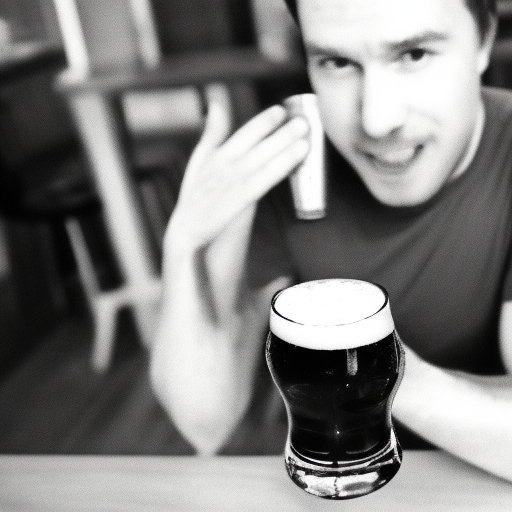

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=25, guidance_scale=9).images[0]
image

In [4]:
def display_grid(images, rows, cols, title):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.axis('off')
    fig.suptitle(title)
    plt.show()
    
def test_gen():
    torch.manual_seed(0)
    images = [pipe(prompt, num_inference_steps=25, guidance_scale=9).images[0] for _ in range(2)]
    display_grid(images, 1, 2, prompt)

In [5]:
patch_pipe(
    pipe,
    tensors_path,
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

<s1>


{'<s1>': tensor([ 0.0003,  0.0080, -0.0190,  ..., -0.0023, -0.0115,  0.0010])}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  8.92it/s]


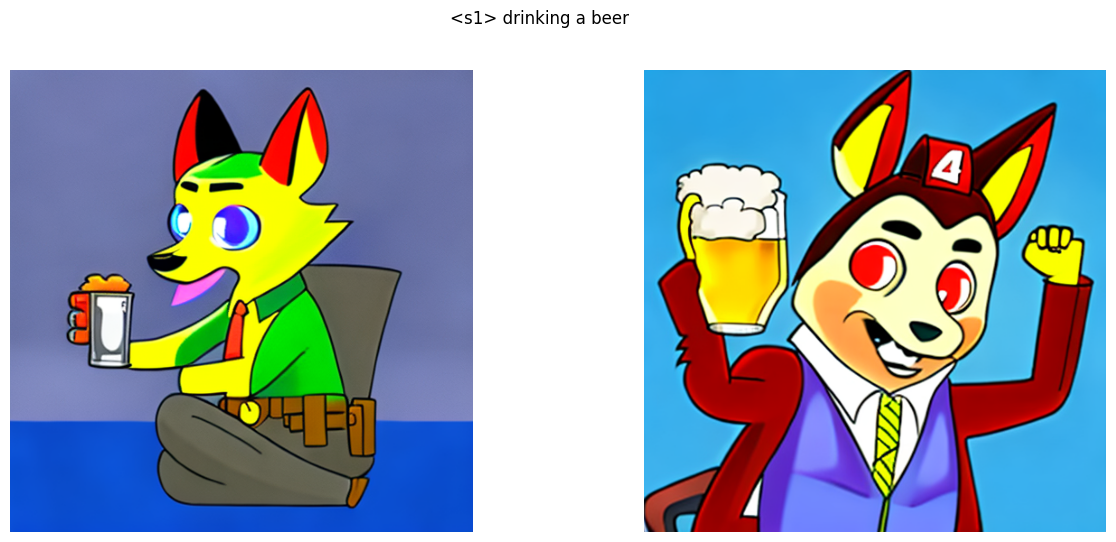

In [8]:
tune_lora_scale(pipe.unet, 1)
tune_lora_scale(pipe.text_encoder, 1)
test_gen()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  8.94it/s]


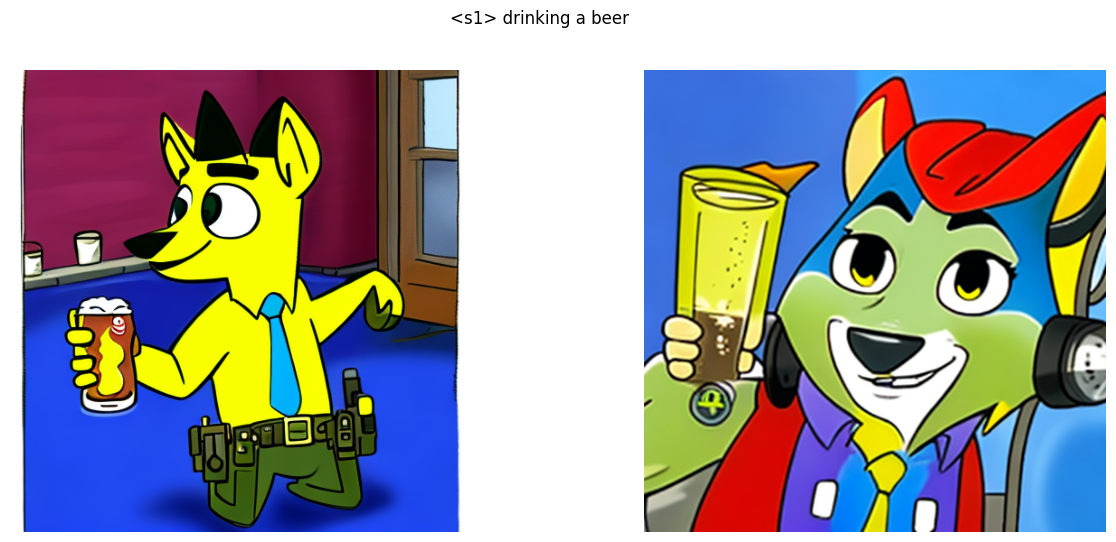

In [7]:
tune_lora_scale(pipe.unet, 0.8)
tune_lora_scale(pipe.text_encoder, 0.8)
test_gen()